In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame
from dslabs_functions import get_variable_types, encode_cyclic_variables, dummify, mvi_by_filling, evaluate_approach, plot_multibar_chart
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer

In [16]:
data: DataFrame = read_csv("datasets/class_pos_covid.csv", index_col=None, na_values=None)
vars: dict[str, list] = get_variable_types(data)

binaries: dict[str, int] = {"no": 0, "No": 0, "yes": 1, "Yes": 1, "Female":0, "Male":1}
encoding: dict[str, dict[str, int]] = {}
for bin_col in vars["binary"]:
	encoding[bin_col] = binaries
df: DataFrame = data.replace(encoding, inplace=False)
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,0,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,0.0,8.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,"Yes, received tetanus shot but not sure what type",0.0,0
1,Alabama,0,Excellent,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,1.60,68.04,26.57,0.0,0.0,0.0,0.0,"No, did not receive any tetanus shot in the pa...",0.0,0
2,Alabama,0,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,1.0,7.0,NaN,0.0,...,1.65,63.50,23.30,0.0,0.0,1.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0
3,Alabama,0,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,1.0,9.0,NaN,0.0,...,1.57,53.98,21.77,1.0,0.0,0.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0
4,Alabama,1,Poor,1.0,0.0,Within past year (anytime less than 12 months ...,0.0,7.0,NaN,1.0,...,1.80,84.82,26.08,0.0,0.0,0.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0


Dorian
state -- population
general health -- ordinal liear
last checkup -- the start of the interval like <1y == 0, >5y == 5
smoker == ecigs -- 00 == nver, 01 == former, 11 == smokes but 
Ruben
race -- dumification
age -- ordinal liear
tetanos -- 00 == no shot, 10 == yes dont know , 11 == yes, knows but not tdap, 12 == yes and is tdap
had diabites -- 00 == no, 10 == yes, 01 == no but is pre diabetic, 11 == yes and before pregancy
teeth -- mid point of interval, 0 teeth = 0, 1-5 == 3, 6+ == 18, all == 32

In [17]:
state : dict[str, int] = {"Virgin Islands": 105870,"Guam": 170534,"Wyoming": 578803,"Vermont": 	645570,
    "District of Columbia": 670050,"Alaska": 732673,"North Dakota": 774948,"South Dakota": 895376,"Delaware": 1003384,
    "Rhode Island": 1095610,"Montana" : 1104271,"Maine": 1372247,"New Hampshire": 1388992,"Hawaii": 1441553,
    "West Virginia": 1782959,"Idaho": 1900923,"Nebraska": 1963692,"New Mexico": 2115877,"Kansas": 2934582,
    "Mississippi": 2949965,"Arkansas": 3025891,"Nevada": 3143991,"Iowa": 3193079,"Puerto Rico": 3263584,
    "Utah": 3337975,"Connecticut": 3605597,"Oklahoma": 3986639,"Oregon": 4246155,"Kentucky": 4509394,
    "Louisiana": 4624047,"Alabama": 5039877,"South Carolina": 5190705,"Minnesota": 5707390,"Colorado": 5812069,
    "Wisconsin": 5895908,"Maryland": 6165129,"Missouri": 6168187,"Indiana": 6805985,"Tennessee": 6975218,
    "Massachusetts": 6984723,"Arizona": 7276316,"Washington": 7738692,"Virginia": 8642274,"New Jersey": 9267130,
    "Michigan" : 10050811,"North Carolina": 10551162,"Georgia": 10799566,"Ohio": 11780017,"Illinois": 12671469,
    "Pennsylvania": 12964056,"New York": 19835913,"Florida": 21781128,"Texas": 29527941,"California": 39237836}

health : dict[str,int] = {"Poor": 0,"Fair": 1,"Good": 2,"Very good": 3,"Excellent": 4}

last : dict[str,int] = {"Within past year (anytime less than 12 months ago)" : 0, 
    "Within past 2 years (1 year but less than 2 years ago)" : 1, 
    'Within past 5 years (2 years but less than 5 years ago)': 2,
    '5 or more years ago': 5}

smoke : dict[str,int] = {"Never smoked": 0,"Former smoker": 1,
    "Current smoker - now smokes some days": 3,
    "Current smoker - now smokes every day": 7}

ecig : dict[str,int] = {"Never used e-cigarettes in my entire life": 0,
    "Not at all (right now)": 1,
    "Use them some days": 3,
    "Use them every day": 7}

encoding['State'] = state
encoding['GeneralHealth'] = health
encoding['LastCheckupTime'] = last
encoding['SmokerStatus'] = smoke
encoding['ECigaretteUsage'] = ecig


df: DataFrame = data.replace(encoding, inplace=False)
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,5039877,0,3.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,"Yes, received tetanus shot but not sure what type",0.0,0
1,5039877,0,4.0,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,1.60,68.04,26.57,0.0,0.0,0.0,0.0,"No, did not receive any tetanus shot in the pa...",0.0,0
2,5039877,0,4.0,0.0,0.0,0.0,1.0,7.0,NaN,0.0,...,1.65,63.50,23.30,0.0,0.0,1.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0
3,5039877,0,1.0,2.0,0.0,0.0,1.0,9.0,NaN,0.0,...,1.57,53.98,21.77,1.0,0.0,0.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0
4,5039877,1,0.0,1.0,0.0,0.0,0.0,7.0,NaN,1.0,...,1.80,84.82,26.08,0.0,0.0,0.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0


# Coding RaceEthnicityCategory
Applied dummification

In [18]:
df = dummify(df, ["RaceEthnicityCategory"])
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic",RaceEthnicityCategory_nan
0,5039877,0,3.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0,...,0.0,"Yes, received tetanus shot but not sure what type",0.0,0,False,False,False,False,True,False
1,5039877,0,4.0,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,0.0,"No, did not receive any tetanus shot in the pa...",0.0,0,False,False,False,False,True,False
2,5039877,0,4.0,0.0,0.0,0.0,1.0,7.0,NaN,0.0,...,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0,False,False,False,False,True,False
3,5039877,0,1.0,2.0,0.0,0.0,1.0,9.0,NaN,0.0,...,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0,False,False,False,False,True,False
4,5039877,1,0.0,1.0,0.0,0.0,0.0,7.0,NaN,1.0,...,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0,False,False,False,False,True,False


# Encoding AgeCategory

just ordinal linear encoding nothing special

In [19]:
AgeCategory: dict[str, int] = {"Age 18 to 24":0, "Age 80 or older":12}
for i in range(11):
	AgeCategory[f'Age {i*5 + 25} to {i*5 + 29}'] = i+1
AgeCategory
encoding: dict[str, dict[str, int]] = {"AgeCategory":AgeCategory}
df: DataFrame = df.replace(encoding, inplace=False)
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic",RaceEthnicityCategory_nan
0,5039877,0,3.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0,...,0.0,"Yes, received tetanus shot but not sure what type",0.0,0,False,False,False,False,True,False
1,5039877,0,4.0,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,0.0,"No, did not receive any tetanus shot in the pa...",0.0,0,False,False,False,False,True,False
2,5039877,0,4.0,0.0,0.0,0.0,1.0,7.0,NaN,0.0,...,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0,False,False,False,False,True,False
3,5039877,0,1.0,2.0,0.0,0.0,1.0,9.0,NaN,0.0,...,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0,False,False,False,False,True,False
4,5039877,1,0.0,1.0,0.0,0.0,0.0,7.0,NaN,1.0,...,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0,False,False,False,False,True,False


# Encoding TetanusLast10Tdap

tetanos -- 00 == no shot, 10 == yes dont know , 11 == yes, knows but not tdap, 12 == yes and is tdap

In [20]:
TetanusLast10Tdap: dict[str, int] = {
	"Yes, received tetanus shot but not sure what type":2, 
	"No, did not receive any tetanus shot in the past 10 years":0, 
	"Yes, received Tdap":7, 
	"Yes, received tetanus shot, but not Tdap":3
}
encoding: dict[str, dict[str, int]] = {"TetanusLast10Tdap":TetanusLast10Tdap}
df: DataFrame = df.replace(encoding, inplace=False)
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic",RaceEthnicityCategory_nan
0,5039877,0,3.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0,...,0.0,2.0,0.0,0,False,False,False,False,True,False
1,5039877,0,4.0,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,0.0,0.0,0.0,0,False,False,False,False,True,False
2,5039877,0,4.0,0.0,0.0,0.0,1.0,7.0,NaN,0.0,...,1.0,0.0,0.0,0,False,False,False,False,True,False
3,5039877,0,1.0,2.0,0.0,0.0,1.0,9.0,NaN,0.0,...,1.0,0.0,0.0,0,False,False,False,False,True,False
4,5039877,1,0.0,1.0,0.0,0.0,0.0,7.0,NaN,1.0,...,1.0,0.0,0.0,0,False,False,False,False,True,False


# Encoding HadDiabetes
had diabites -- 00 == no, 10 == yes, 01 == no but is pre diabetic, 11 == yes and before pregancy

In [21]:
HadDiabetes: dict[str, int] = {
	"No, pre-diabetes or borderline diabetes":1, 
	"Yes, but only during pregnancy (female)":3, 
	"Yes":2, 
	"No":0
}
encoding: dict[str, dict[str, int]] = {"HadDiabetes":HadDiabetes}
df: DataFrame = df.replace(encoding, inplace=False)
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic",RaceEthnicityCategory_nan
0,5039877,0,3.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0,...,0.0,2.0,0.0,0,False,False,False,False,True,False
1,5039877,0,4.0,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,0.0,0.0,0.0,0,False,False,False,False,True,False
2,5039877,0,4.0,0.0,0.0,0.0,1.0,7.0,NaN,0.0,...,1.0,0.0,0.0,0,False,False,False,False,True,False
3,5039877,0,1.0,2.0,0.0,0.0,1.0,9.0,NaN,0.0,...,1.0,0.0,0.0,0,False,False,False,False,True,False
4,5039877,1,0.0,1.0,0.0,0.0,0.0,7.0,NaN,1.0,...,1.0,0.0,0.0,0,False,False,False,False,True,False


# Encoding RemovedTeeth

encode with the mid point of the interval

i.e. 0 teeth == 0, 1-5 == 2, 6+ == 18, all == 32

In [22]:
RemovedTeeth: dict[str, int] = {"None of them":0, "1 to 5":2, "6 or more, but not all":18, "All":32}
encoding: dict[str, dict[str, int]] = {"RemovedTeeth":RemovedTeeth}
df: DataFrame = df.replace(encoding, inplace=False)
df.head()


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic",RaceEthnicityCategory_nan
0,5039877,0,3.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0,...,0.0,2.0,0.0,0,False,False,False,False,True,False
1,5039877,0,4.0,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,0.0,0.0,0.0,0,False,False,False,False,True,False
2,5039877,0,4.0,0.0,0.0,0.0,1.0,7.0,NaN,0.0,...,1.0,0.0,0.0,0,False,False,False,False,True,False
3,5039877,0,1.0,2.0,0.0,0.0,1.0,9.0,NaN,0.0,...,1.0,0.0,0.0,0,False,False,False,False,True,False
4,5039877,1,0.0,1.0,0.0,0.0,0.0,7.0,NaN,1.0,...,1.0,0.0,0.0,0,False,False,False,False,True,False


# Missing Value Imputation

## Approach 1

remove all records with mv

In [23]:
df_mvi_a1: DataFrame = df.dropna(how="any", inplace=False)
df_mvi_a1 = df_mvi_a1.drop(df_mvi_a1[df_mvi_a1["RaceEthnicityCategory_nan"] == True].index)
df_mvi_a1 = df_mvi_a1.drop(columns=["RaceEthnicityCategory_nan"])
df_mvi_a1

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic"
252,5039877,0,3.0,4.0,0.0,0.0,1.0,9.0,0.0,0.0,...,1.0,1.0,7.0,0.0,0,False,False,False,False,True
253,5039877,1,3.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,...,1.0,1.0,2.0,0.0,0,False,False,False,False,True
255,5039877,0,2.0,3.0,15.0,0.0,1.0,5.0,2.0,0.0,...,1.0,1.0,0.0,0.0,0,False,False,False,False,True
256,5039877,1,2.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0,False,False,False,False,True
257,5039877,0,2.0,3.0,0.0,0.0,1.0,8.0,18.0,0.0,...,1.0,1.0,0.0,0.0,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380918,105870,1,2.0,0.0,0.0,0.0,0.0,6.0,18.0,0.0,...,0.0,1.0,3.0,0.0,1,True,False,False,False,False
380920,105870,1,1.0,7.0,30.0,0.0,0.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1,True,False,False,False,False
380927,105870,0,1.0,0.0,7.0,0.0,1.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,True,False,False,False,False
380928,105870,1,2.0,0.0,15.0,0.0,1.0,7.0,2.0,0.0,...,1.0,1.0,2.0,0.0,1,False,False,True,False,False


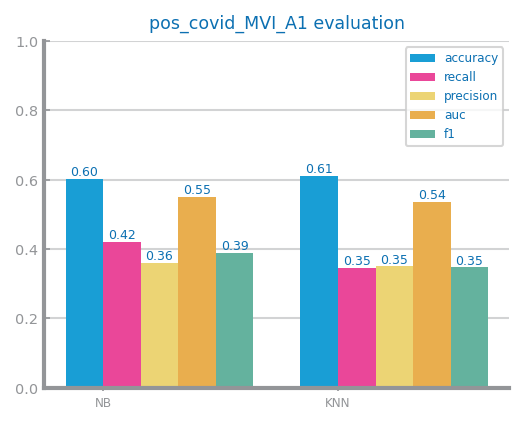

In [24]:
target = "CovidPos"
file_tag = "class_pos_covid_MVI_A1"

x = df_mvi_a1.drop(columns=[target])
y = df_mvi_a1[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test,y_test], axis=1)

plt.figure()
eval: dict[str, list] = evaluate_approach(df_train, df_test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
plt.savefig(f"images/{file_tag}_eval.png")
plt.show()

## Approach 2
dont remove every record with missing values

In [25]:
df_mvi_a2 = mvi_by_filling(df, strategy="frequent")
value_counnts = data["RaceEthnicityCategory"].value_counts()
most_occurences_value = f"RaceEthnicityCategory_{value_counnts.idxmax()}"

df_mvi_a2.loc[df_mvi_a2["RaceEthnicityCategory_nan"] == True, most_occurences_value] = True

df_mvi_a2 = df_mvi_a2.drop(columns=["RaceEthnicityCategory_nan"])
df_mvi_a2

,State,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,SleepHours,RemovedTeeth,HadDiabetes,SmokerStatus,ECigaretteUsage,...,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic"
0,5039877.0,3.0,0.0,0.0,0.000000,8.0,4.433718,2.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5039877.0,4.0,0.0,0.0,0.426368,6.0,4.433718,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5039877.0,4.0,0.0,0.0,0.000000,7.0,4.433718,0.0,3.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5039877.0,1.0,2.0,0.0,0.000000,9.0,4.433718,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5039877.0,0.0,1.0,0.0,0.000000,7.0,4.433718,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380927,105870.0,1.0,0.0,7.0,0.000000,7.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
380928,105870.0,2.0,0.0,15.0,0.000000,7.0,2.000000,2.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
380929,105870.0,2.0,0.0,0.0,1.000000,8.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
380930,105870.0,2.0,0.0,3.0,1.000000,6.0,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


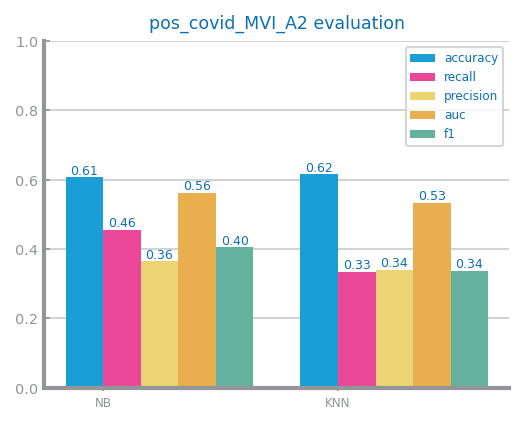

In [26]:
target = "CovidPos"
file_tag = "class_pos_covid_MVI_A2"
train, test = train_test_split(df_mvi_a2, test_size=0.2)

plt.figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
plt.savefig(f"images/{file_tag}_eval.png")
plt.show()

## Selecting approach

In [27]:
df = df_mvi_a2
df

,State,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,SleepHours,RemovedTeeth,HadDiabetes,SmokerStatus,ECigaretteUsage,...,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic"
0,5039877.0,3.0,0.0,0.0,0.000000,8.0,4.433718,2.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5039877.0,4.0,0.0,0.0,0.426368,6.0,4.433718,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5039877.0,4.0,0.0,0.0,0.000000,7.0,4.433718,0.0,3.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5039877.0,1.0,2.0,0.0,0.000000,9.0,4.433718,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5039877.0,0.0,1.0,0.0,0.000000,7.0,4.433718,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380927,105870.0,1.0,0.0,7.0,0.000000,7.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
380928,105870.0,2.0,0.0,15.0,0.000000,7.0,2.000000,2.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
380929,105870.0,2.0,0.0,0.0,1.000000,8.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
380930,105870.0,2.0,0.0,3.0,1.000000,6.0,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
